# *(Tian, et al., 2020)* E/I Net for fast response

Implementation of the paper： 

- *Tian, Gengshuo, et al. "Excitation-Inhibition Balanced Neural Networks for Fast Signal Detection." Frontiers in Computational Neuroscience 14 (2020): 79.*

Author:

- Chaoming Wang (chao.brain@qq.com)

In [1]:
import brainpy as bp

In [2]:
# set parameters

num = 10000
num_inh = int(num * 0.2)
num_exc = num - num_inh
prob = 0.25

tau_E = 15.
tau_I = 10.
V_reset = 0.
V_threshold = 15.
f_E = 3.
f_I = 2.
mu_f = 0.1

tau_Es = 6.
tau_Is = 5.
JEE = 0.25
JEI = -1.
JIE = 0.4
JII = -1.

In [3]:
# define neuron type


class LIF(bp.NeuGroup):
  target_backend = 'numpy'

  def __init__(self, size, tau, **kwargs):
    super(LIF, self).__init__(size, **kwargs)

    # parameters
    self.tau = tau

    # variables
    self.V = bp.math.Variable(bp.math.zeros(size))
    self.spike = bp.math.Variable(bp.math.zeros(size, dtype=bool))
    self.input = bp.math.Variable(bp.math.zeros(size))

  @bp.odeint
  def int_V(self, V, t, Isyn):
    return (-V + Isyn) / self.tau

  def update(self, _t, _dt):
    for i in range(self.num):
      V = self.int_V(self.V[i], _t, self.input[i])
      if V >= V_threshold:
        self.spike[i] = True
        V = V_reset
      else:
        self.spike[i] = False
      self.V[i] = V
      self.input[i] = 0.

In [4]:
# define synapse type

class Syn(bp.TwoEndConn):
  target_backend = 'numpy'

  def __init__(self, pre, post, conn, tau, g_max, **kwargs):
    super(Syn, self).__init__(pre, post, conn=conn, **kwargs)

    # parameters
    self.tau = tau
    self.g_max = g_max

    # connections
    self.pre2post = self.conn.requires('pre2post')

    # variables
    self.s = bp.math.Variable(bp.math.zeros(post.num))

  @bp.odeint
  def ints(self, s, t):
    return - s / self.tau

  def update(self, _t, _dt):
    self.s[:] = self.ints(self.s, _t)
    for pre_i, spike in enumerate(self.pre.spike):
      if spike:
        for post_i in self.pre2post[pre_i]:
          self.s[post_i] += 1.
    self.post.input += self.g_max * self.s

In [5]:
# build & simulate network
E = LIF(num_exc, tau=tau_E, name='E', monitors=['spike'])
E.V[:] = bp.math.random.random(num_exc) * (V_threshold - V_reset) + V_reset

I = LIF(num_inh, tau=tau_I, name='I', monitors=['spike'])
I.V[:] = bp.math.random.random(num_inh) * (V_threshold - V_reset) + V_reset

E2I = Syn(pre=E, post=I, conn=bp.connect.FixedProb(prob=prob), tau=tau_Es, g_max=JIE)
E2E = Syn(pre=E, post=E, conn=bp.connect.FixedProb(prob=prob), tau=tau_Es, g_max=JEE)
I2I = Syn(pre=I, post=I, conn=bp.connect.FixedProb(prob=prob), tau=tau_Is, g_max=JII)
I2E = Syn(pre=I, post=E, conn=bp.connect.FixedProb(prob=prob), tau=tau_Is, g_max=JEI)

net = bp.Network(E, I, I2E, E2E, I2I, E2I)
net = bp.math.jit(net)

net.run(duration=100.,
        inputs=[('E.input', f_E * bp.math.sqrt(num) * mu_f),
                ('I.input', f_I * bp.math.sqrt(num) * mu_f)],
        report=0.1)

Compilation used 3.5793 s.
Start running ...
Run 10.0% used 0.013 s.
Run 20.0% used 0.025 s.
Run 30.0% used 0.036 s.
Run 40.0% used 0.048 s.
Run 50.0% used 0.059 s.
Run 60.0% used 0.070 s.
Run 70.0% used 0.082 s.
Run 80.0% used 0.093 s.
Run 90.0% used 0.104 s.
Run 100.0% used 0.116 s.
Simulation is done in 0.116 s.



0.11647748947143555

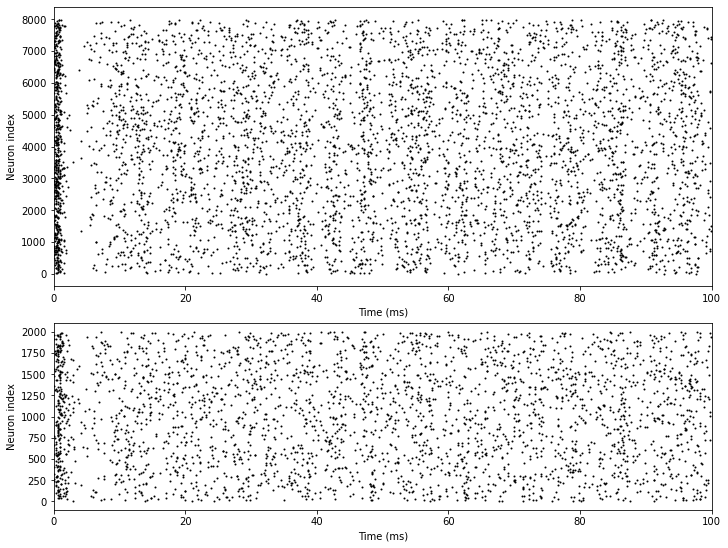

In [6]:
# visualization
fig, gs = bp.visualize.get_figure(5, 1, 1.5, 10)

fig.add_subplot(gs[:3, 0])
bp.visualize.raster_plot(E.mon.ts, E.mon.spike, xlim=(0, 100))

fig.add_subplot(gs[3:, 0])
bp.visualize.raster_plot(I.mon.ts, I.mon.spike, xlim=(0, 100), show=True)